In [1]:
import torch
import xgboost as xgb
import pandas as pd
import shap
import matplotlib.pyplot as plt
import mlflow
from IPython.display import IFrame
from sklearn.metrics import (  # type: ignore
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

from src.data.data_spliter import DataSplitter
from src.data.data_utils import (
    find_first_positive,
    find_last_positive,
    load_data,
    merge_multiple_dataframes,
    validate_no_label_leakage,
    compare_timestamps,
)
from src.models.datasets import LSTMFailureDataset, XGBoostFailureDataset, generate_flat_feature_names
from src.models.metric_visualizer import plot_loss_accuracy, print_rec_pres_acc
from src.models.lstm import LSTMNetwork
from src.transformations.features import (
    add_time_since_last_event_features,
    encode_machine_model,
    encode_time,
)

### Constants

In [2]:
ignored_columns = [
    "errorID", "failure", "maint_comp1", "maint_comp2", "maint_comp3", "maint_comp4",
    "failure_comp1", "failure_comp2", "failure_comp3", "failure_comp4",
    "code_error1", "code_error2", "code_error3", "code_error4", "code_error5", "model",
]
HORIZON = 24
drop_cols = ["datetime", "machineID"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###  Data Loading and Preprocessing

In [3]:
dfs = load_data()
final_df = merge_multiple_dataframes(dfs)
final_df = add_time_since_last_event_features(final_df)
final_df = encode_time(final_df)
final_df = encode_machine_model(final_df)

###  Train/Val/Test Split

In [4]:
splitter = DataSplitter(
    seq_len=25,
    horizon=HORIZON,
    random_state=42,
    ignore_columns=ignored_columns,
    split_by_time=True,
    enable_scaling=True,
)
train_split, val_split, test_split = splitter.create_splits(final_df)


In [5]:
print("Train size: ",len(train_split))
print("Val size: ",len(val_split))
print("Test size: ",len(test_split))

Train size:  908
Val size:  170373
Test size:  170366


### Data Leakage Validation 

In [6]:
print('Chek labels are as expected in a case') 
if first_positive := find_first_positive(train_split):
    validate_no_label_leakage(first_positive[0], dfs["PdM_failures"], horizon=HORIZON)

if last_positive := find_last_positive(train_split):
    validate_no_label_leakage(last_positive[0], dfs["PdM_failures"], horizon=HORIZON)
print('Compare timestamps in train and val splits')
compare_timestamps(train_split, val_split)

Chek labels are as expected in a case
✅ No data leakage detected.
✅ Expected failure found at: 2015-03-06 06:00:00
✅ No data leakage detected.
✅ Expected failure found at: 2015-02-12 06:00:00
Compare timestamps in train and val splits
📅 Earliest timestamp in train: 2015-01-02 05:00:00
📅 Latest timestamp in train: 2015-08-07 05:00:00
📅 Earliest timestamp in validation: 2015-08-09 05:00:00
📅 Latest timestamp in validation: 2015-10-19 06:00:00
Is there any time leakage: False


### LSTM Model Training and Evaluation

In [7]:
train_dataset = LSTMFailureDataset(train_split, drop_cols=drop_cols)
val_dataset = LSTMFailureDataset(val_split, drop_cols=drop_cols)
test_dataset = LSTMFailureDataset(test_split, drop_cols=drop_cols)

input_dim = train_split[0][0].shape[1] - len(drop_cols)

lstm = LSTMNetwork(
    input_dim=input_dim,
    device=device,
    hidden_size=128,
    num_layers=2,
    num_classes=2,
    dropout=0.3,
    lr=0.0003,
    epochs=20,
)

lstm.fit(train_dataset=train_dataset, val_dataset=val_dataset)

result = lstm.evaluate(test_dataset=test_dataset, return_confusion_matrix=True)

if len(result) == 3:
    print_rec_pres_acc(result)

run = lstm.get_run()

Training:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 6/14 [00:00<00:00, 56.90it/s]
                                                                                                                                                                                             
Training Epochs:   5%|██████▊                                                                                                                                 | 1/20 [00:28<09:03, 28.63s/it]

Epoch 01 | Train Loss: 0.6840, Acc: 0.5826 | Val Loss: 0.7259, Acc: 0.1294



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 95.27it/s]
                                                                                                                                                                                             
Training Epochs:  10%|█████████████▌                                                                                                                          | 2/20 [00:52<07:49, 26.09s/it]

Epoch 02 | Train Loss: 0.6200, Acc: 0.8359 | Val Loss: 0.7063, Acc: 0.4797



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 99.77it/s]
                                                                                                                                                                                             
Training Epochs:  15%|████████████████████▍                                                                                                                   | 3/20 [01:17<07:08, 25.20s/it]

Epoch 03 | Train Loss: 0.4296, Acc: 0.8984 | Val Loss: 0.5474, Acc: 0.7215



Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 11/14 [00:00<00:00, 100.16it/s]
                                                                                                                                                                                             
Training Epochs:  20%|███████████████████████████▏                                                                                                            | 4/20 [01:41<06:40, 25.05s/it]

Epoch 04 | Train Loss: 0.1822, Acc: 0.9498 | Val Loss: 0.5291, Acc: 0.7474



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.64it/s]
                                                                                                                                                                                             
Training Epochs:  25%|██████████████████████████████████                                                                                                      | 5/20 [02:06<06:13, 24.88s/it]

Epoch 05 | Train Loss: 0.0787, Acc: 0.9777 | Val Loss: 0.5044, Acc: 0.8013



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.95it/s]
                                                                                                                                                                                             
Training Epochs:  30%|████████████████████████████████████████▊                                                                                               | 6/20 [02:31<05:48, 24.92s/it]

Epoch 06 | Train Loss: 0.0543, Acc: 0.9833 | Val Loss: 0.3497, Acc: 0.8652



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.37it/s]
                                                                                                                                                                                             
Training Epochs:  35%|███████████████████████████████████████████████▌                                                                                        | 7/20 [02:56<05:25, 25.00s/it]

Epoch 07 | Train Loss: 0.0384, Acc: 0.9911 | Val Loss: 0.3768, Acc: 0.8636



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.47it/s]
                                                                                                                                                                                             
Training Epochs:  40%|██████████████████████████████████████████████████████▍                                                                                 | 8/20 [03:21<05:00, 25.03s/it]

Epoch 08 | Train Loss: 0.0325, Acc: 0.9911 | Val Loss: 0.5003, Acc: 0.8342



Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 11/14 [00:00<00:00, 100.51it/s]
                                                                                                                                                                                             
Training Epochs:  45%|█████████████████████████████████████████████████████████████▏                                                                          | 9/20 [03:46<04:34, 24.91s/it]

Epoch 09 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.4937, Acc: 0.8393



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 99.25it/s]
                                                                                                                                                                                             
Training Epochs:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 10/20 [04:10<04:07, 24.71s/it]

Epoch 10 | Train Loss: 0.0324, Acc: 0.9900 | Val Loss: 0.8086, Acc: 0.7620



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 96.66it/s]
                                                                                                                                                                                             
Training Epochs:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 11/20 [04:35<03:41, 24.64s/it]

Epoch 11 | Train Loss: 0.0466, Acc: 0.9810 | Val Loss: 0.3320, Acc: 0.8891



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.47it/s]
                                                                                                                                                                                             
Training Epochs:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 12/20 [04:59<03:16, 24.60s/it]

Epoch 12 | Train Loss: 0.0241, Acc: 0.9911 | Val Loss: 0.3046, Acc: 0.9042



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 99.06it/s]
                                                                                                                                                                                             
Training Epochs:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 13/20 [05:24<02:53, 24.75s/it]

Epoch 13 | Train Loss: 0.0237, Acc: 0.9944 | Val Loss: 0.6349, Acc: 0.8111



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 94.96it/s]
                                                                                                                                                                                             
Training Epochs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14/20 [05:49<02:28, 24.79s/it]

Epoch 14 | Train Loss: 0.0200, Acc: 0.9944 | Val Loss: 0.3159, Acc: 0.9022



Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 11/14 [00:00<00:00, 101.34it/s]
                                                                                                                                                                                             
Training Epochs:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15/20 [06:14<02:03, 24.70s/it]

Epoch 15 | Train Loss: 0.0148, Acc: 0.9978 | Val Loss: 0.4339, Acc: 0.8697



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.32it/s]
                                                                                                                                                                                             
Training Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16/20 [06:38<01:38, 24.73s/it]

Epoch 16 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.4181, Acc: 0.8799



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 99.72it/s]
                                                                                                                                                                                             
Training Epochs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17/20 [07:03<01:14, 24.73s/it]

Epoch 17 | Train Loss: 0.0094, Acc: 0.9978 | Val Loss: 0.4095, Acc: 0.8873



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.35it/s]
                                                                                                                                                                                             
Training Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [07:28<00:49, 24.73s/it]

Epoch 18 | Train Loss: 0.0088, Acc: 0.9978 | Val Loss: 0.4408, Acc: 0.8863



Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 11/14 [00:00<00:00, 100.86it/s]
                                                                                                                                                                                             
Training Epochs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [07:52<00:24, 24.68s/it]

Epoch 19 | Train Loss: 0.0103, Acc: 0.9978 | Val Loss: 0.6693, Acc: 0.8405



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.70it/s]
                                                                                                                                                                                             
Training Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:17<00:00, 24.86s/it]
2025/04/07 21:29:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 20 | Train Loss: 0.0062, Acc: 0.9989 | Val Loss: 0.4279, Acc: 0.8943


2025/04/07 21:30:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 21:30:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


LSTM Evaluation:
[[151943  18286]
 [     2    135]]
Accuracy: 0.8927
Recall:   0.9854
Precision:0.0073
Loss:     0.4347


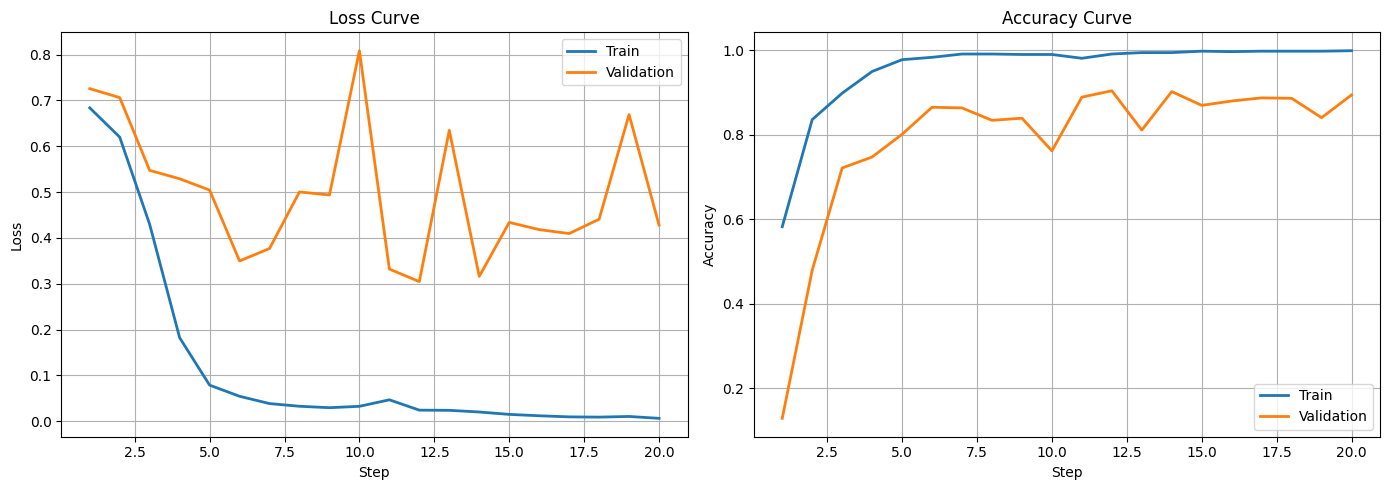

In [8]:
client = mlflow.tracking.MlflowClient()
run_id = run.run_id

plot_loss_accuracy(client, run_id)


In [9]:
splitter = DataSplitter(
    seq_len=25,
    horizon=HORIZON,
    random_state=42,
    ignore_columns=ignored_columns,
    split_by_time=True,
    enable_scaling=True,
    balance_val_test=True
    
)
train_split_balance, val_split_balance, test_split_balance = splitter.create_splits(final_df)
print("Train size: ",len(train_split_balance))
print("Val size: ",len(val_split_balance))
print("Test size: ",len(test_split_balance))

Train size:  908
Val size:  288
Test size:  274


In [25]:
train_dataset_balance = LSTMFailureDataset(train_split_balance, drop_cols=drop_cols)
val_dataset_balance = LSTMFailureDataset(val_split_balance, drop_cols=drop_cols)
test_dataset_balance = LSTMFailureDataset(test_split_balance, drop_cols=drop_cols)

input_dim_balance = train_split_balance[0][0].shape[1] - len(drop_cols)

lstm = LSTMNetwork(
    input_dim=input_dim_balance,
    device=device,
    hidden_size=128,
    num_layers=2,
    num_classes=2,
    dropout=0.3,
    lr=0.0003,
    epochs=20,
)

lstm.fit(train_dataset=train_dataset_balance, val_dataset=val_dataset_balance)

result_balance = lstm.evaluate(test_dataset=test_dataset_balance, return_confusion_matrix=True)

if len(result) == 3:
    print_rec_pres_acc(result_balance)

run = lstm.get_run()

Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 94.00it/s]
                                                                                                                                                                                             
Training Epochs:   5%|██████▊                                                                                                                                 | 1/20 [00:00<00:03,  5.16it/s]

Epoch 01 | Train Loss: 0.6896, Acc: 0.5636 | Val Loss: 0.6795, Acc: 0.7847



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.21it/s]
                                                                                                                                                                                             
Training Epochs:  10%|█████████████▌                                                                                                                          | 2/20 [00:00<00:03,  5.19it/s]

Epoch 02 | Train Loss: 0.6686, Acc: 0.7254 | Val Loss: 0.6496, Acc: 0.7604



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.24it/s]
                                                                                                                                                                                             
Training Epochs:  15%|████████████████████▍                                                                                                                   | 3/20 [00:00<00:03,  5.21it/s]

Epoch 03 | Train Loss: 0.5933, Acc: 0.7723 | Val Loss: 0.4365, Acc: 0.8507



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.33it/s]
                                                                                                                                                                                             
Training Epochs:  20%|███████████████████████████▏                                                                                                            | 4/20 [00:00<00:03,  5.24it/s]

Epoch 04 | Train Loss: 0.3917, Acc: 0.8493 | Val Loss: 0.2725, Acc: 0.8924



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.43it/s]
                                                                                                                                                                                             
Training Epochs:  25%|██████████████████████████████████                                                                                                      | 5/20 [00:00<00:02,  5.26it/s]

Epoch 05 | Train Loss: 0.3031, Acc: 0.8839 | Val Loss: 0.2503, Acc: 0.9201



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 92.04it/s]
                                                                                                                                                                                             
Training Epochs:  30%|████████████████████████████████████████▊                                                                                               | 6/20 [00:01<00:02,  5.21it/s]

Epoch 06 | Train Loss: 0.2687, Acc: 0.9062 | Val Loss: 0.2411, Acc: 0.9132



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.47it/s]
                                                                                                                                                                                             
Training Epochs:  35%|███████████████████████████████████████████████▌                                                                                        | 7/20 [00:01<00:02,  5.23it/s]

Epoch 07 | Train Loss: 0.2461, Acc: 0.9174 | Val Loss: 0.2795, Acc: 0.8993



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.75it/s]
                                                                                                                                                                                             
Training Epochs:  40%|██████████████████████████████████████████████████████▍                                                                                 | 8/20 [00:01<00:02,  5.25it/s]

Epoch 08 | Train Loss: 0.2437, Acc: 0.9174 | Val Loss: 0.2501, Acc: 0.9132



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 99.03it/s]
                                                                                                                                                                                             
Training Epochs:  45%|█████████████████████████████████████████████████████████████▏                                                                          | 9/20 [00:01<00:02,  5.28it/s]

Epoch 09 | Train Loss: 0.2273, Acc: 0.9185 | Val Loss: 0.2399, Acc: 0.9271



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.25it/s]
                                                                                                                                                                                             
Training Epochs:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 10/20 [00:01<00:01,  5.28it/s]

Epoch 10 | Train Loss: 0.2401, Acc: 0.9163 | Val Loss: 0.2339, Acc: 0.9236



Training:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 9/14 [00:00<00:00, 89.92it/s]
                                                                                                                                                                                             
Training Epochs:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 11/20 [00:02<00:01,  5.12it/s]

Epoch 11 | Train Loss: 0.2167, Acc: 0.9275 | Val Loss: 0.3667, Acc: 0.8750



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 92.57it/s]
                                                                                                                                                                                             
Training Epochs:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 12/20 [00:02<00:01,  5.07it/s]

Epoch 12 | Train Loss: 0.2306, Acc: 0.9252 | Val Loss: 0.2444, Acc: 0.9097



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 90.98it/s]
                                                                                                                                                                                             
Training Epochs:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 13/20 [00:02<00:01,  5.07it/s]

Epoch 13 | Train Loss: 0.2155, Acc: 0.9208 | Val Loss: 0.2609, Acc: 0.9132



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.47it/s]
                                                                                                                                                                                             
Training Epochs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14/20 [00:02<00:01,  5.12it/s]

Epoch 14 | Train Loss: 0.2036, Acc: 0.9252 | Val Loss: 0.2383, Acc: 0.9062



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 99.04it/s]
                                                                                                                                                                                             
Training Epochs:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15/20 [00:02<00:00,  5.18it/s]

Epoch 15 | Train Loss: 0.1955, Acc: 0.9330 | Val Loss: 0.2346, Acc: 0.9236



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 98.33it/s]
                                                                                                                                                                                             
Training Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16/20 [00:03<00:00,  5.21it/s]

Epoch 16 | Train Loss: 0.1930, Acc: 0.9319 | Val Loss: 0.2444, Acc: 0.9236



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.14it/s]
                                                                                                                                                                                             
Training Epochs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17/20 [00:03<00:00,  5.22it/s]

Epoch 17 | Train Loss: 0.1976, Acc: 0.9330 | Val Loss: 0.2601, Acc: 0.9097



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.40it/s]
                                                                                                                                                                                             
Training Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [00:03<00:00,  5.22it/s]

Epoch 18 | Train Loss: 0.1777, Acc: 0.9408 | Val Loss: 0.2538, Acc: 0.9167



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.29it/s]
                                                                                                                                                                                             
Training Epochs:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [00:03<00:00,  5.24it/s]

Epoch 19 | Train Loss: 0.1780, Acc: 0.9375 | Val Loss: 0.2512, Acc: 0.9201



Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 10/14 [00:00<00:00, 97.52it/s]
                                                                                                                                                                                             
Training Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 20 | Train Loss: 0.1866, Acc: 0.9353 | Val Loss: 0.2582, Acc: 0.9097


2025/04/07 22:12:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 22:12:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 22:12:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
                                                                       

LSTM Evaluation:
[[122  15]
 [  5 132]]
Accuracy: 0.9270
Recall:   0.9635
Precision:0.8980
Loss:     0.1903


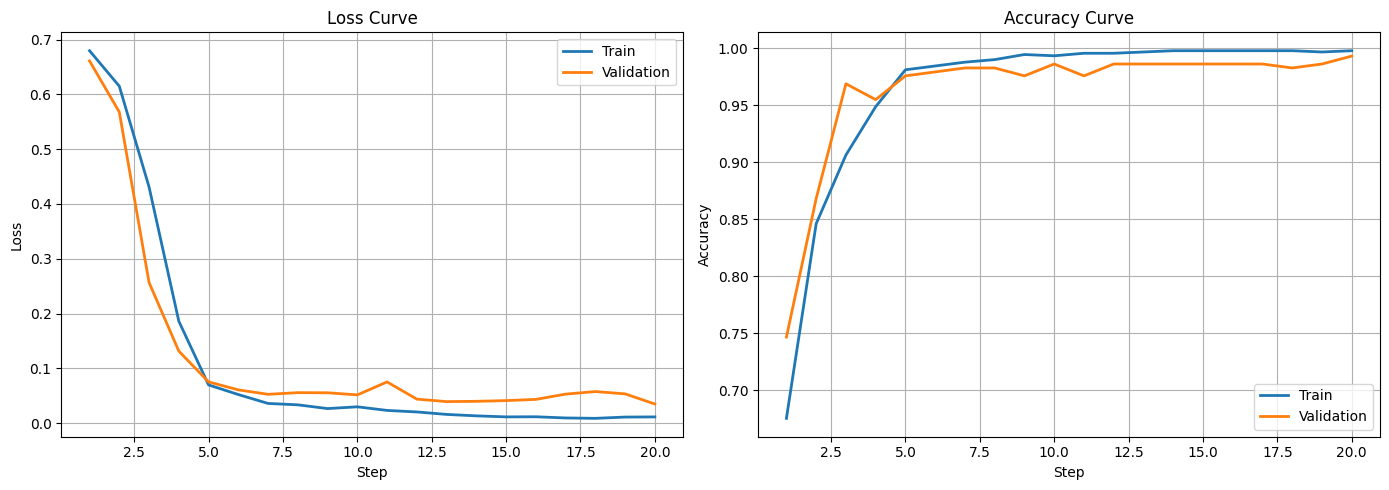

In [11]:
run_id_balance = run.run_id

plot_loss_accuracy(client, run_id_balance)

In [12]:
mlflow_url = "http://localhost:5000"
IFrame(src=mlflow_url, width='100%', height=600)

### XGBoost Training

In [13]:
xgbtrain_dataset = XGBoostFailureDataset(train_split, drop_cols=drop_cols, flatten_method="stack")
X_train, y_train = xgbtrain_dataset.get_data()

xgbtest_dataset = XGBoostFailureDataset(test_split, drop_cols=drop_cols, flatten_method="stack")
X_test, y_test = xgbtest_dataset.get_data()

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [14]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("\nXGBoost Evaluation Metrics on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


XGBoost Evaluation Metrics on Test Set:
Accuracy:  0.9117
Precision: 0.0090
Recall:    1.0000
F1 Score:  0.0179
AUC:       0.9885

Confusion Matrix:
[[155183  15046]
 [     0    137]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9116    0.9538    170229
           1     0.0090    1.0000    0.0179       137

    accuracy                         0.9117    170366
   macro avg     0.5045    0.9558    0.4858    170366
weighted avg     0.9992    0.9117    0.9530    170366



### SHAP Explainability

/tmp/ipykernel_4033760/790815716.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


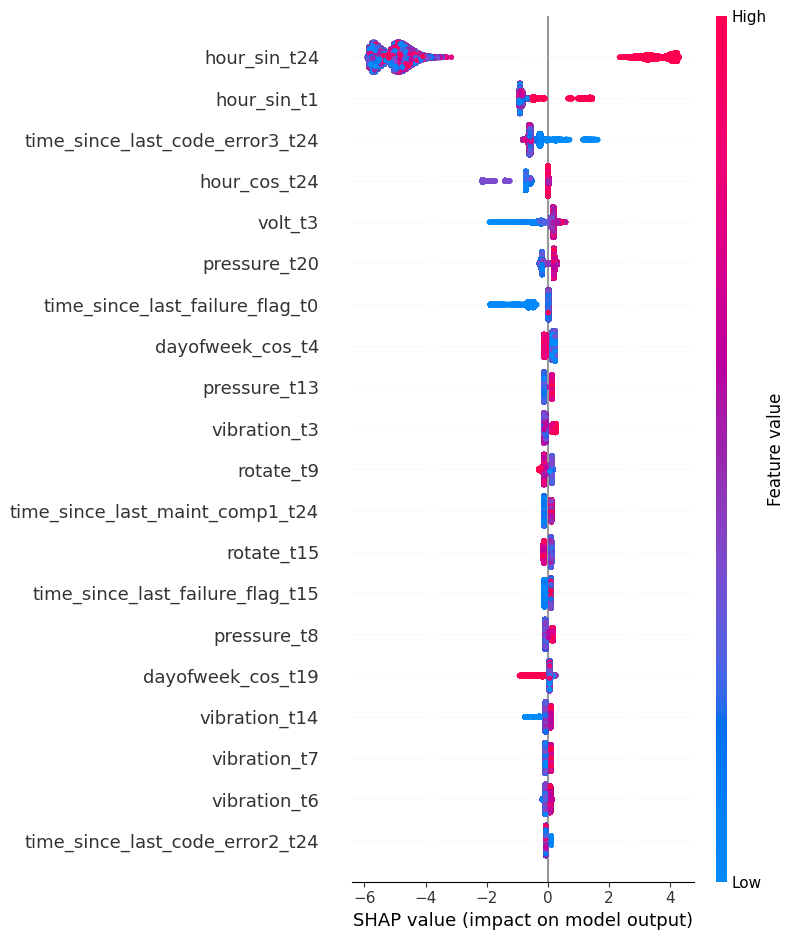

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=generate_flat_feature_names(test_split[0][0], drop_cols)
)

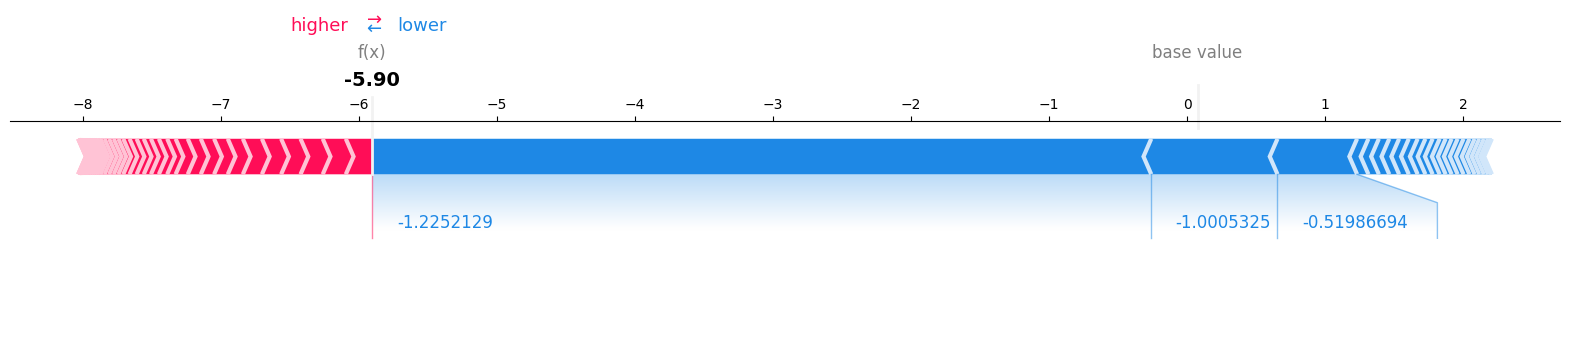

In [16]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], matplotlib=True)

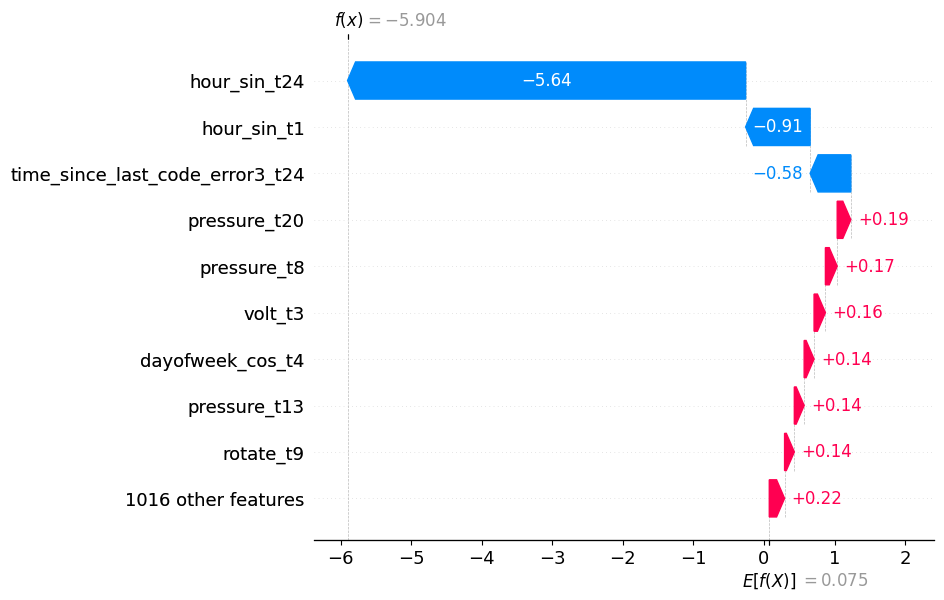

In [17]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
   feature_names=generate_flat_feature_names(test_split[0][0], drop_cols),
)


In [18]:
drop_cols = drop_cols + ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
xgbtrain_dataset = XGBoostFailureDataset(train_split, drop_cols=drop_cols, flatten_method="stack")
X_train, y_train = xgbtrain_dataset.get_data()

xgbtest_dataset = XGBoostFailureDataset(test_split, drop_cols=drop_cols, flatten_method="stack")
X_test, y_test = xgbtest_dataset.get_data()

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [19]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("\nXGBoost Evaluation Metrics on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


XGBoost Evaluation Metrics on Test Set:
Accuracy:  0.9533
Precision: 0.0168
Recall:    0.9927
F1 Score:  0.0331
AUC:       0.9949

Confusion Matrix:
[[162277   7952]
 [     1    136]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9533    0.9761    170229
           1     0.0168    0.9927    0.0331       137

    accuracy                         0.9533    170366
   macro avg     0.5084    0.9730    0.5046    170366
weighted avg     0.9992    0.9533    0.9753    170366



/tmp/ipykernel_4033760/790815716.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


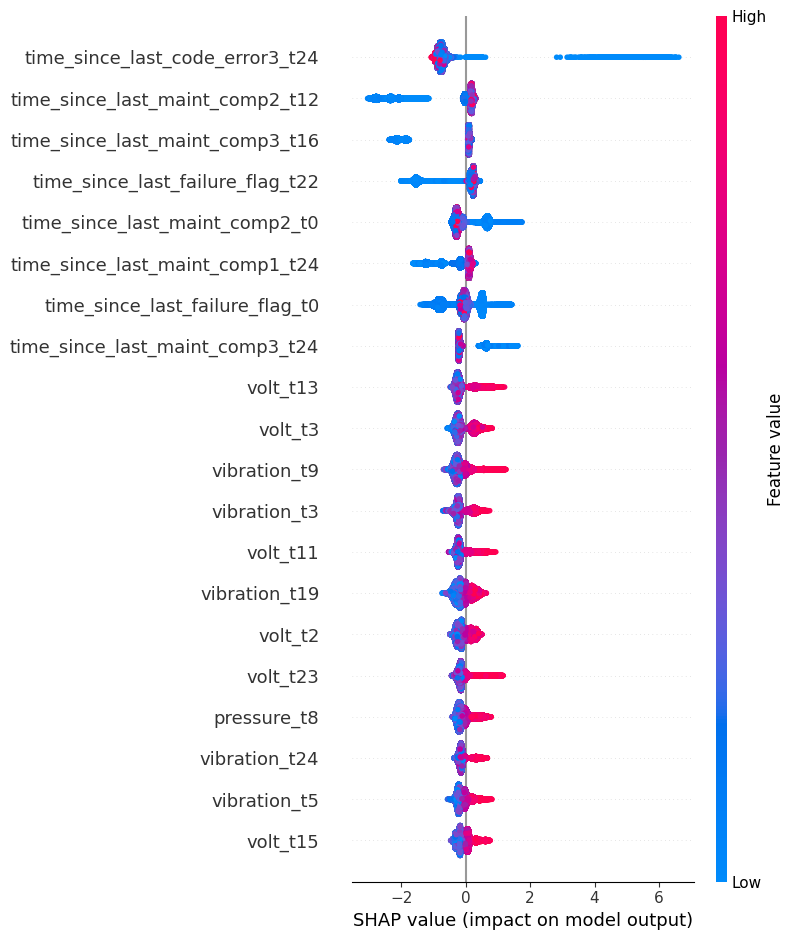

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=generate_flat_feature_names(test_split[0][0], drop_cols)
)

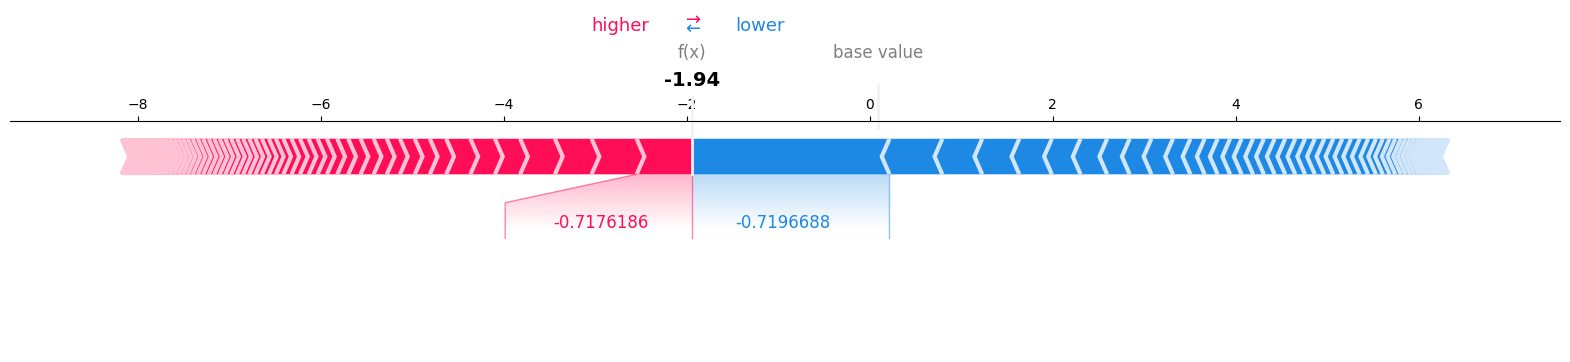

In [21]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], matplotlib=True)

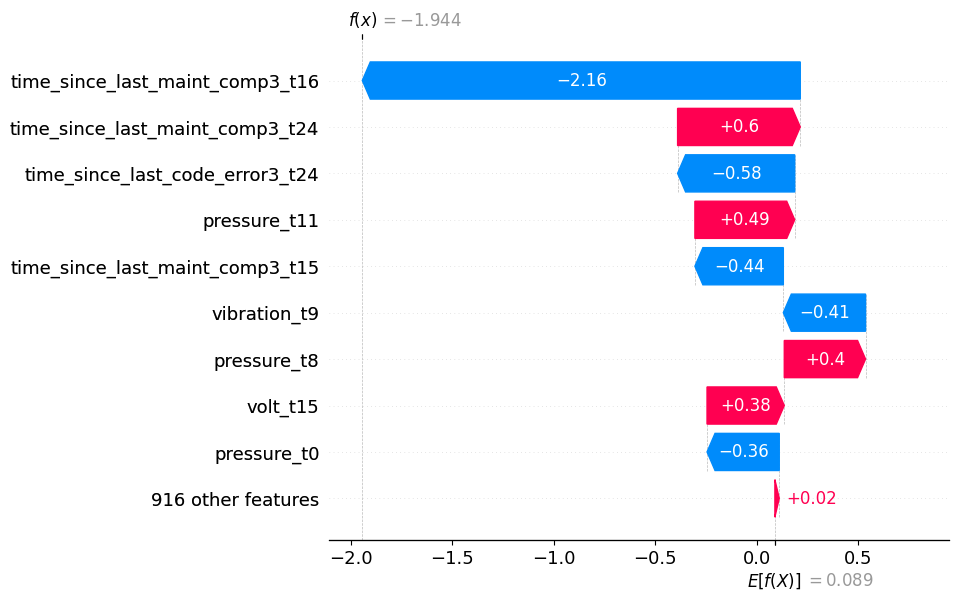

In [22]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
   feature_names=generate_flat_feature_names(test_split[0][0], drop_cols),
)


The XGBoost model demonstrated strong performance in distinguishing between normal and failure conditions, achieving an overall accuracy of 95.33% and an AUC of 0.9949, indicating excellent discrimination capability. However, due to the extreme class imbalance, the precision for detecting failures (class 1) was low at 0.0168, while recall reached 99.27%, ensuring that nearly all failures were correctly identified. The corresponding F1 score of 0.0331 reflects the trade-off between capturing rare events and minimizing false positives. SHAP value analysis revealed that recent maintenance events and sensor trends — especially time_since_last_maint_comp3_t16, pressure_t11, and vibration_t9 — played a key role in influencing model predictions. These features, predominantly contributing negatively to the model’s output, indicate that recency of component servicing and abnormal sensor patterns were strongly associated with impending failures. The model's explainability insights, paired with its high recall, make it a valuable tool for early detection and proactive intervention, even though further tuning or post-processing (e.g., threshold adjustment or cost-sensitive learning) may be necessary to improve precision for practical deployment.

In [23]:
xgbtrain_dataset = XGBoostFailureDataset(train_split_balance, drop_cols=drop_cols, flatten_method="stack")
X_train, y_train = xgbtrain_dataset.get_data()

xgbtest_dataset = XGBoostFailureDataset(test_split_balance, drop_cols=drop_cols, flatten_method="stack")
X_test, y_test = xgbtest_dataset.get_data()

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("\nXGBoost Evaluation Metrics on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


XGBoost Evaluation Metrics on Test Set:
Accuracy:  0.9672
Precision: 0.9444
Recall:    0.9927
F1 Score:  0.9680
AUC:       0.9975

Confusion Matrix:
[[129   8]
 [  1 136]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9923    0.9416    0.9663       137
           1     0.9444    0.9927    0.9680       137

    accuracy                         0.9672       274
   macro avg     0.9684    0.9672    0.9671       274
weighted avg     0.9684    0.9672    0.9671       274

